<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-NEB-end-structures" data-toc-modified-id="Prepare-NEB-end-structures-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare NEB end structures</a></span><ul class="toc-item"><li><span><a href="#Download-from-Materials-Project-and-create-supercell" data-toc-modified-id="Download-from-Materials-Project-and-create-supercell-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Download from Materials Project and create supercell</a></span></li><li><span><a href="#Relax-supercells-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet" data-toc-modified-id="Relax-supercells-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Relax supercells with M3GNet-DIRECT, M3GNet-MS, and CHGNet</a></span></li><li><span><a href="#Create-and-relax-NEB-end-structures----b-and-c-directions" data-toc-modified-id="Create-and-relax-NEB-end-structures----b-and-c-directions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create and relax NEB end structures -- b and c directions</a></span></li></ul></li><li><span><a href="#NEB-calculations-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet" data-toc-modified-id="NEB-calculations-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>NEB calculations with M3GNet-DIRECT, M3GNet-MS, and CHGNet</a></span><ul class="toc-item"><li><span><a href="#generate-NEB-images-from-end-structures-and-conduct-NEB" data-toc-modified-id="generate-NEB-images-from-end-structures-and-conduct-NEB-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>generate NEB images from end structures and conduct NEB</a></span></li><li><span><a href="#analyze-and-plot-NEB-results" data-toc-modified-id="analyze-and-plot-NEB-results-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>analyze and plot NEB results</a></span></li><li><span><a href="#Store-NEB-images-in-one-cif-file-for-visualization" data-toc-modified-id="Store-NEB-images-in-one-cif-file-for-visualization-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Store NEB images in one cif file for visualization</a></span></li><li><span><a href="#Visualize-NEB-path-(snapshots-of-VESTA-visualization-of-path_final.cif)" data-toc-modified-id="Visualize-NEB-path-(snapshots-of-VESTA-visualization-of-path_final.cif)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Visualize NEB path (snapshots of VESTA visualization of path_final.cif)</a></span></li></ul></li></ul></div>


DFT barrier heights: path b = 0.27 eV and path c = 2.5 eV. (see table 1 in https://doi.org/10.1039/C5TA05062F)


In [ ]:
from __future__ import annotations

from ase.neb import NEBTools
from pymatgen.ext.matproj import MPRester

from matcalc import NEBCalc, PESCalculator, RelaxCalc

mpr = MPRester()

# Prepare NEB end structures


## Download from Materials Project and create supercell


In [ ]:
s_LFPO = mpr.get_structure_by_material_id("mp-19017")
s_LFPO.make_supercell([1, 2, 2], in_place=True)
s_LFPO.to("NEB_data/LiFePO4_supercell.cif", "cif")
s_LFPO.lattice.abc, s_LFPO.formula

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

((10.23619605, 11.941510200000154, 9.309834380000202), 'Li16 Fe16 P16 O64')

## Relax supercells with M3GNet-DIRECT, M3GNet-MS, and CHGNet


In [ ]:
models = {
    "M3GNet-DIRECT": PESCalculator.load_universal("M3GNet-MP-2021.2.8-DIRECT-PES"),
}

In [ ]:
%%time
results = {}
for model_name, model in models.items():
    relaxer = RelaxCalc(model, optimizer="BFGS", relax_cell=True, fmax=0.02)
    supercell_LFPO_relaxed = relaxer.calc(s_LFPO)["final_structure"]
    results[model_name] = {"supercell_LFPO": supercell_LFPO_relaxed}

CPU times: user 1min 24s, sys: 2min 50s, total: 4min 15s
Wall time: 41.2 s


## Create and relax NEB end structures -- b and c directions


In [ ]:
%%time
for model_name, model in models.items():
    relaxer = RelaxCalc(model, optimizer="BFGS", relax_cell=False, fmax=0.02)
    supercell_LFPO_relaxed = results[model_name]["supercell_LFPO"]

    # NEB path along b and c directions have the same starting image.
    s_LFPO_end_b = supercell_LFPO_relaxed.copy()
    s_LFPO_end_b.remove_sites([11])
    s_LFPO_end_b_relaxed = relaxer.calc(s_LFPO_end_b)["final_structure"]
    s_LFPO_end_c = supercell_LFPO_relaxed.copy()
    s_LFPO_end_c.remove_sites([4])
    s_LFPO_end_c_relaxed = relaxer.calc(s_LFPO_end_c)["final_structure"]
    s_LFPO_start_bc = supercell_LFPO_relaxed.copy()
    s_LFPO_start_bc.remove_sites([5])
    s_LFPO_start_bc_relaxed = relaxer.calc(s_LFPO_start_bc)["final_structure"]
    results[model_name].update(
        {
            "supercell_LFPO_end_b": s_LFPO_end_b_relaxed,
            "supercell_LFPO_end_c": s_LFPO_end_c_relaxed,
            "supercell_LFPO_start_bc": s_LFPO_start_bc_relaxed,
        }
    )

KeyboardInterrupt: 

# NEB calculations with M3GNet-DIRECT, M3GNet-MS, and CHGNet

The universal potentials provide reasonable agreement with each other and with literature.

References:

1. https://pubs.rsc.org/en/content/articlelanding/2011/ee/c1ee01782a
2. https://doi.org/10.1103/PhysRevApplied.7.034007


## generate NEB images from end structures and conduct NEB


In [ ]:
%%time
for neb_path in "bc":
    for model_name, model in models.items():
        NEBcalc = NEBCalc.from_end_images(
            start_struct=results[model_name]["supercell_LFPO_start_bc"],
            end_struct=results[model_name][f"supercell_LFPO_end_{neb_path}"],
            calculator=model,
            n_images=7,
            climb=True,
            traj_folder=f"NEB_data/traj_{neb_path}_{model_name}/",
        )
        barrier = NEBcalc.calc(fmax=0.05)[0]
        results[model_name][f"NEB_{neb_path}"] = NEBcalc.neb
        print(f"Barrier along {neb_path} by {model_name}: {barrier} eV.")

KeyError: 'supercell_LFPO_start_bc'

## analyze and plot NEB results


In [ ]:
%%time
import matplotlib.pyplot as plt

for neb_path in "bc":
    for model_name, model in models.items():
        NEB_tool = NEBTools(results[model_name][f"NEB_{neb_path}"].images)
        print(f"Path along {neb_path}, {model_name}: ")
        fig = NEB_tool.plot_band()
        plt.show()

KeyError: 'NEB_b'

## Store NEB images in one cif file for visualization


In [ ]:
from itertools import chain

from pymatgen.core import PeriodicSite, Structure
from pymatgen.io.ase import AseAtomsAdaptor


def generate_path_cif_from_images(images: list, filename: str) -> None:
    """Generate a cif file from a list of image atoms."""
    image_structs = list(map(AseAtomsAdaptor().get_structure, images))
    sites = set()
    lattice = image_structs[0].lattice
    sites.update(
        PeriodicSite(site.species, site.frac_coords, lattice) for site in chain(*(struct for struct in image_structs))
    )
    neb_path = Structure.from_sites(sorted(sites))
    neb_path.to(filename, "cif")

In [ ]:
%%time
for neb_path in "bc":
    for model_name, model in models.items():
        NEB_tool = NEBTools(results[model_name][f"NEB_{neb_path}"].images)
        generate_path_cif_from_images(NEB_tool.images, f"NEB_data/traj_{neb_path}_{model_name}/path_final.cif")

KeyError: 'NEB_b'

## Visualize NEB path (snapshots of VESTA visualization of path_final.cif)


In [ ]:
from IPython.display import Image

Final path b by M3GNet-DIRECT:


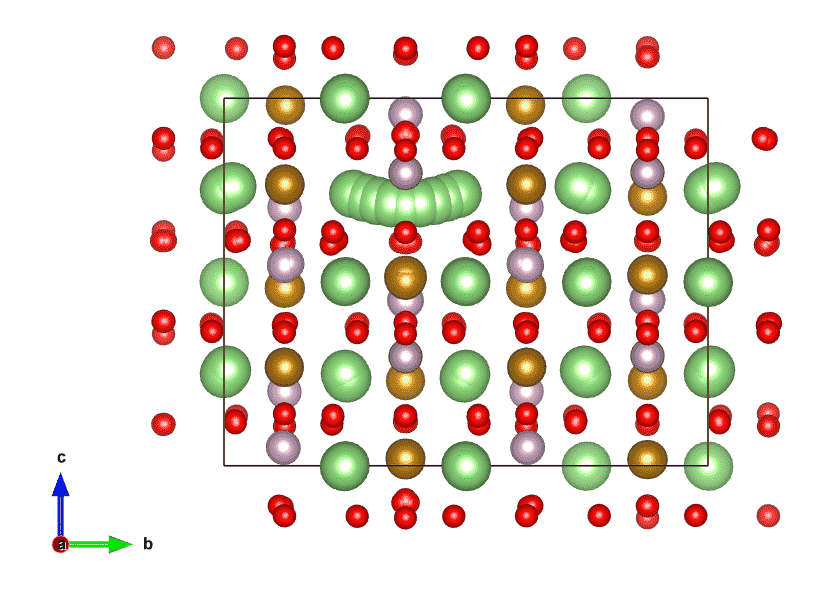

In [ ]:
print("Final path b by M3GNet-DIRECT:")
Image("NEB_data/M3GNet-DIRECT-path-b.png")

Final path c by M3GNet-DIRECT:


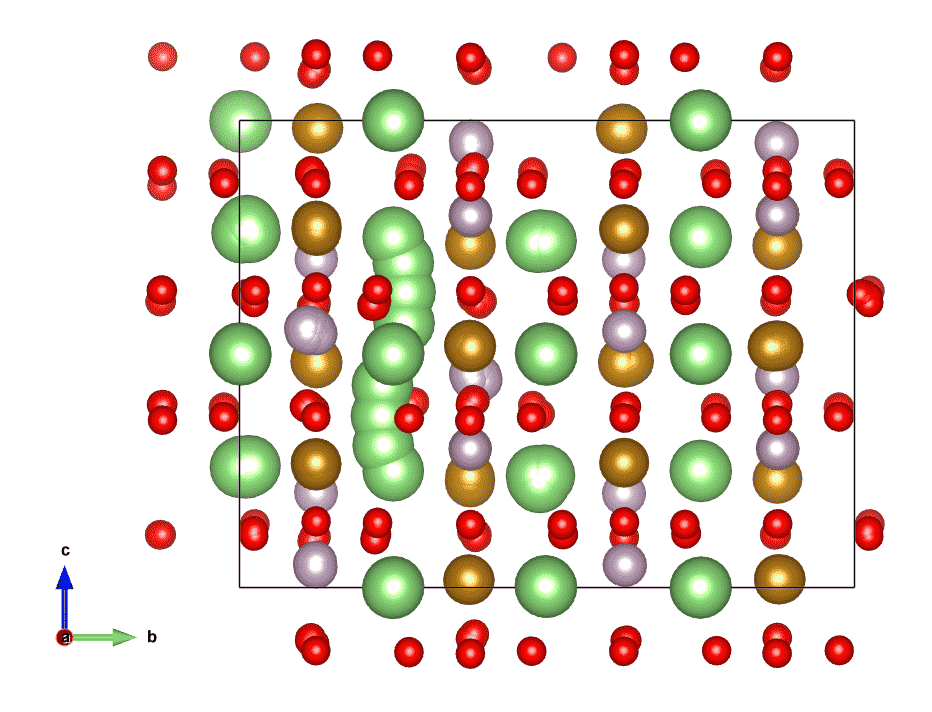

In [ ]:
print("Final path c by M3GNet-DIRECT:")
Image("NEB_data/M3GNet-DIRECT-path-c.png")